In [1]:
import pandas as pd
import scanpy as sc
from utils import plot_phase_plane
import scvelo as scv

In [6]:
import scanpy as sc

def preprocess_adata(adata, 
                     min_genes=200, 
                     min_cells=3, 
                     mt_prefix='MT-', 
                     max_mt_percent=5, 
                     normalization_target=1e4, 
                     min_mean=0.0125, 
                     max_mean=3, 
                     min_disp=0.5):
    """
    Preprocess AnnData object: Filter low-quality cells/genes, normalize data,
    and select highly variable genes.

    Parameters:
    - adata: AnnData object
    - min_genes: Minimum number of genes expressed in a cell to retain the cell
    - min_cells: Minimum number of cells expressing a gene to retain the gene
    - mt_prefix: Prefix for mitochondrial genes (e.g., 'MT-' for human)
    - max_mt_percent: Maximum percentage of mitochondrial gene counts to retain a cell
    - normalization_target: Target sum for total counts normalization
    - min_mean: Minimum mean expression for highly variable genes
    - max_mean: Maximum mean expression for highly variable genes
    - min_disp: Minimum dispersion for highly variable genes

    Returns:
    - Preprocessed AnnData object
    """
    # Step 1: Filter low-quality cells and genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # Step 2: Annotate and filter mitochondrial gene content
    adata.var['mt'] = adata.var_names.str.startswith(mt_prefix)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs['pct_counts_mt'] < max_mt_percent, :]

    # Step 3: Normalize and log-transform data
    sc.pp.normalize_total(adata, target_sum=normalization_target)
    sc.pp.log1p(adata)

    # Step 4: Identify and filter for highly variable genes
    sc.pp.highly_variable_genes(
        adata,
        min_mean=min_mean,
        max_mean=max_mean,
        min_disp=min_disp,
        n_top_genes=2000,
        flavor="seurat_v3"
    )
    adata = adata[:, adata.var['highly_variable']]

    return adata


In [2]:
path = "/mnt/data2/home/leonardo/git/mkVelo/neurips/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad"
adata = sc.read_h5ad(path)

In [5]:
gex = adata[:,adata.var["feature_types"] == "GEX"].copy()
atac = adata[:,adata.var["feature_types"] == "ATAC"].copy()

In [7]:
gex = preprocess_adata(gex)
atac = preprocess_adata(atac)

: 

In [15]:
import numpy as np
# Combine features (variables)
adata_combined = sc.AnnData(
    X=np.hstack([gex.X.toarray(), atac.X.toarray()]),  # Concatenate the X matrices (sparse format)
    obs=gex.obs,                # Use the shared observations
    var=pd.concat([gex.var, atac.var], ignore_index=True)  # Concatenate variable metadata
)

: 

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.tl.velocity

In [6]:
adata.obs["cell_type"]

TAGTTGTCACCCTCAC-1-s1d1     Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1        CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1            CD8+ T
TCATTTGGTAATGGAA-1-s1d1            CD8+ T
ACCACATAGGTGTCCA-1-s1d1        CD16+ Mono
                                ...      
AAACCGCGTTTGAGGC-12-s4d9     CD8+ T naive
TGACTTAAGTTCCCGT-12-s4d9       Lymph prog
GCTGTACCACCGTTCC-12-s4d9           CD8+ T
ACACTTGCAACTAGAA-12-s4d9             cDC2
CACTTAAAGTCTGGGC-12-s4d9    Naive CD20+ B
Name: cell_type, Length: 69249, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [17]:
rna_umi = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv")
adt_clr = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


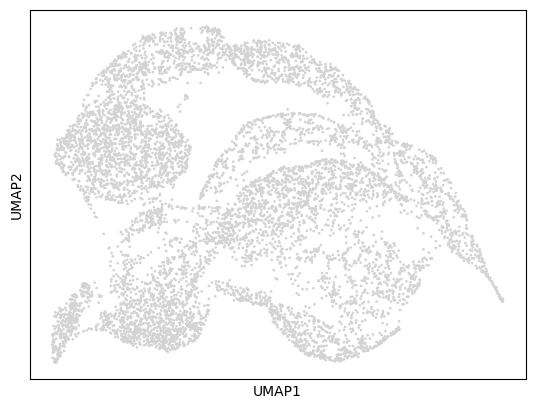

In [31]:
adt_umi = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv").T

obs_names = adt_umi.index[1:]
var_names = adt_umi.iloc[0,:]
data = adt_umi.iloc[1:,].values

adt = sc.AnnData(X=data)
adt.obs_names = obs_names
adt.var_names = var_names
sc.pp.neighbors(adt)
sc.tl.umap(adt)
sc.pl.umap(adt)

In [40]:
adt.var_names

Index(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14', 'CD11c',
       'CD19'],
      dtype='object', name='Unnamed: 0')

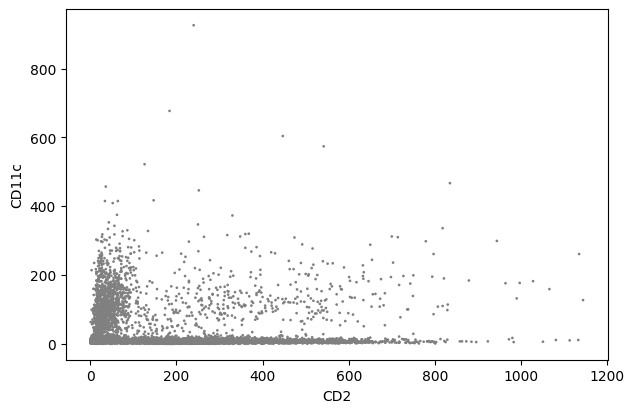

In [47]:
sc.pl.scatter(adt, x="CD2", y="CD11c")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


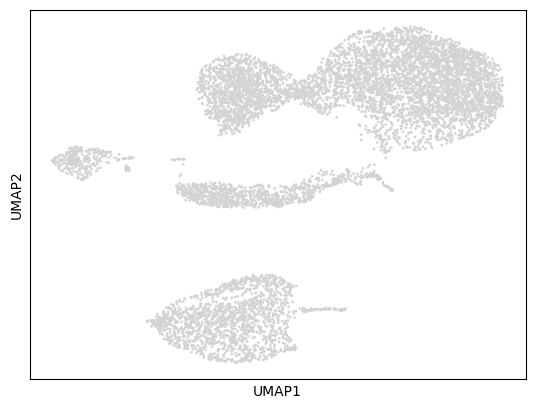

In [32]:
adt_clr = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv").T
obs_names = adt_clr.index[1:]
var_names = adt_clr.iloc[0,:]
data = adt_clr.iloc[1:,].values
adt_clr = sc.AnnData(X=data)
adt_clr.obs_names = obs_names
adt_clr.var_names = var_names
sc.pp.neighbors(adt_clr)
sc.tl.umap(adt_clr)
sc.pl.umap(adt_clr)

In [38]:
rna_umi_df = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv").T


KeyboardInterrupt: 

In [37]:
rna_umi_df

,Unnamed: 0,ACCGTAAGTGTAATGA,CGTGAGCTCGAGAACG,CACATTTAGAATTCCC,TACGGTATCTGGGCCA,TCAGGTAGTAAGTTCC,TGATTTCGTTCTCATT,ACACTGAAGGCCCTCA,ACGGGTCGTCACACGC,AGCTTGACATCCCATC,...,TTCTCCTAGATCGATA,GGAAAGCGTCGACTAT,GACTAACCAACACCCG,AGCGTCGTCCTCGCAT,TCTCATAAGTTTGCGT,GTCGGGTAGAGCTGGT,GTCGGGTAGGTAGCCA,GTCGGGTAGTCTTGCA,ATGTGTGGTCCGTTAA,CGTATGCCGTCTTCTG
0,HUMAN_A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HUMAN_A1BG-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HUMAN_A2M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HUMAN_A2M-AS1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,HUMAN_AAAS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29924,MOUSE_mt-Tm,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29925,MOUSE_mt-Tp,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29926,MOUSE_mt-Tq,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29927,MOUSE_mt-Tt,3,0,3,2,2,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0


         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


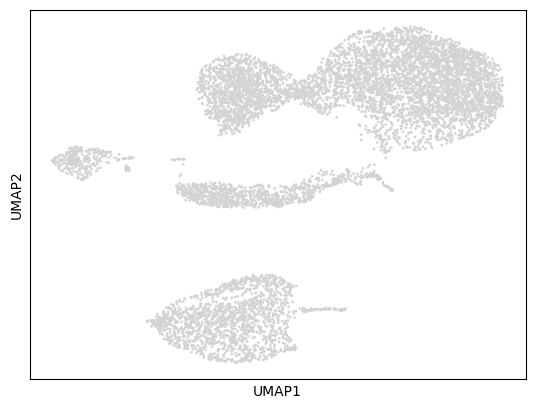

In [39]:
rna_umi = pd.read_csv("/mnt/data2/home/leonardo/git/mkVelo/CITE-seq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv").T
obs_names = rna_umi.index[1:]
var_names = rna_umi.iloc[0,:]
data = rna_umi.iloc[1:,].values
rna_umi = sc.AnnData(X=data)
rna_umi.obs_names = obs_names
rna_umi.var_names = var_names
sc.pp.neighbors(rna_umi)
sc.tl.umap(rna_umi)
sc.pl.umap(rna_umi)

In [7]:
rna_umi.head().T

,0,1,2,3,4
Unnamed: 0,HUMAN_A1BG,HUMAN_A1BG-AS1,HUMAN_A2M,HUMAN_A2M-AS1,HUMAN_AAAS
ACCGTAAGTGTAATGA,0,0,0,0,0
CGTGAGCTCGAGAACG,0,0,0,0,0
CACATTTAGAATTCCC,0,0,0,0,0
TACGGTATCTGGGCCA,0,0,0,0,0
...,...,...,...,...,...
GTCGGGTAGAGCTGGT,0,0,0,0,1
GTCGGGTAGGTAGCCA,0,0,0,0,0
GTCGGGTAGTCTTGCA,0,0,0,0,0
ATGTGTGGTCCGTTAA,0,0,0,0,0
